Load the Health 'Concerns' dataset
------------------------------------
Fetch the JSON data from `data.gg`:

In [1]:
import requests
# fetch the data
json_concerns = requests.get('http://data.gg/api/1.0/health/concerns.json').text
# print some of the content out to check that we have retrieved it ok
json_concerns[:200]

u'[{"Year":2005,"All screenings":1864,"Body Mass Index greater or equal to 30":299,"Diabetes found in screening":8,"Raised Blood Pressure":145,"Raised Cholesterol":137,"Abnormal ECG":null,"Visceral Fat '

Read the JSON data into a dataframe:

In [2]:
import pandas
# parse the JSON into a Pandas dataframe
df = pandas.read_json(json_concerns)
# print out the first few rows of the dataframe
df.head()

,Abnormal ECG,All screenings,Body Mass Index greater or equal to 30,Diabetes found in screening,Raised Blood Pressure,Raised Cholesterol,Visceral Fat greater than 13,Year
0,NaN,1864,299,8,145,137,NaN,2005
1,NaN,1944,328,9,154,183,NaN,2006
2,15,1983,378,7,201,301,NaN,2007
3,30,1999,335,6,181,299,320,2008
4,20,2133,346,5,228,259,422,2009


**Note:** The `NaN` entries indicate missing data.

The data is indexed by year, so let's make that explicit in the dataframe:

In [3]:
# modify the dataframe index
df.set_index('Year', inplace=True)

Some of the column headings are a bit verbose - let's shorten them to make them easier to work with:

In [4]:
df.rename(columns={
        'Body Mass Index greater or equal to 30' : 'High BMI',
        'Diabetes found in screening' : 'Diabetes found',
        'Visceral Fat greater than 13' : 'High Visceral Fat',
    }, inplace=True)
df.head()

,Abnormal ECG,All screenings,High BMI,Diabetes found,Raised Blood Pressure,Raised Cholesterol,High Visceral Fat
Year,,,,,,,
2005,NaN,1864,299,8,145,137,NaN
2006,NaN,1944,328,9,154,183,NaN
2007,15,1983,378,7,201,301,NaN
2008,30,1999,335,6,181,299,320
2009,20,2133,346,5,228,259,422


The dataframe is in better shape now - let's start using it...

How do the screening totals vary over the years?
--------------------------------------------------
The number of concerns raised per year need to be considered relative to the total number of screenings that year, so let's first look at how the total screenings vary:

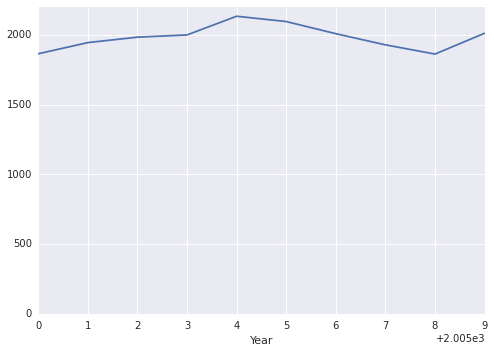

In [5]:
# needed to plot graphs inline
%matplotlib inline
import seaborn

df['All screenings'].plot(ylim=(0,2200))

**TODO:** need to fix the x-axis numbering on these plots

We can see that this is fairly consistent around the 2000 mark.
In fact, we can trivially calculate the historical average:

In [6]:
df['All screenings'].mean()

1982.7

Calculate proportions relative to yearly totals
-------------------------------------------------
Although we have seen that the total screening rates don't change much between years, to more accurately compare the rates of various concerns, we should consider them _relative_ to the yearly total screenings, rather than as absolute values in their own right.

To do this, we will compute some new columns that are simple percentages of the screening totals.
Let's put these values in a new dataframe, `df_relative`, to avoid confusion:

In [7]:
# make a new dataframe and copy the 'Year' index into it
df_relative = pandas.DataFrame(index=df.index)

# calculate the relative occurrence rates and scale to be percentages
df_relative['Abnormal ECG %'] = (df['Abnormal ECG'] / df['All screenings']) * 100.0
df_relative['High BMI %'] = (df['High BMI'] / df['All screenings']) * 100.0
df_relative['Diabetes found %'] = (df['Diabetes found'] / df['All screenings']) * 100.0
df_relative['Raised Blood Pressure %'] = (df['Raised Blood Pressure'] / df['All screenings']) * 100.0
df_relative['Raised Cholesterol %'] = (df['Raised Cholesterol'] / df['All screenings']) * 100.0
df_relative['High Visceral Fat %'] = (df['High Visceral Fat'] / df['All screenings']) * 100.0

df_relative.head()

,Abnormal ECG %,High BMI %,Diabetes found %,Raised Blood Pressure %,Raised Cholesterol %,High Visceral Fat %
Year,,,,,,
2005,NaN,16.040773,0.429185,7.778970,7.349785,NaN
2006,NaN,16.872428,0.462963,7.921811,9.413580,NaN
2007,0.756430,19.062027,0.353001,10.136157,15.179022,NaN
2008,1.500750,16.758379,0.300150,9.054527,14.957479,16.008004
2009,0.937647,16.221285,0.234412,10.689170,12.142522,19.784341


Let's now plot these out to see if there are any obvious candidates for further investigation:

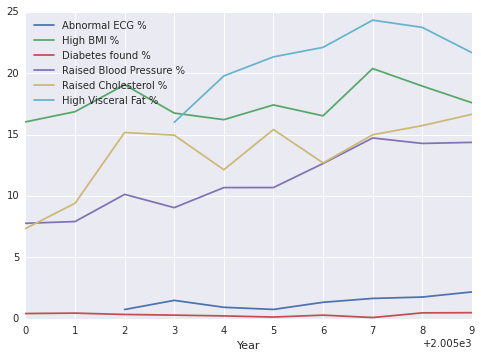

In [8]:
df_relative.plot()

That's not very helpful - the plot legend obscures our data lines!
Let's move the legend outside of the plot:

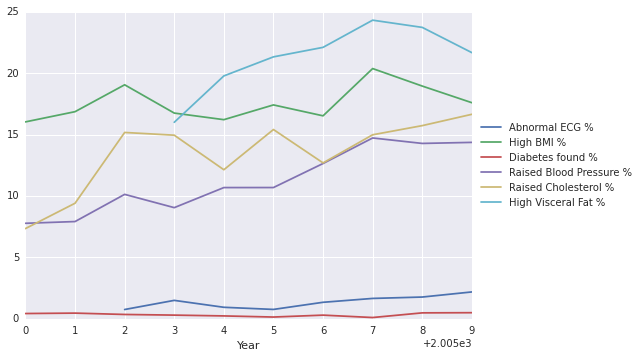

In [9]:
import matplotlib.pyplot as plt
df_relative.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

That's better!
But a couple of these are too small to be seen clearly on this combined plot, so let's plot them in a separate figure with a different y axis scale:

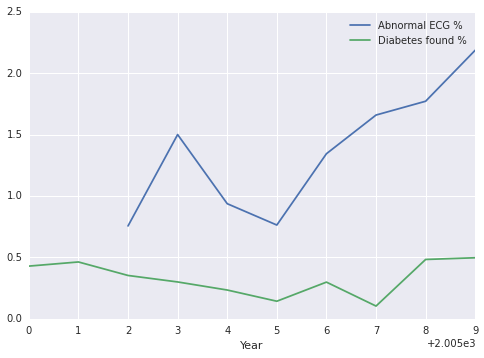

In [10]:
# extract the two columns into a temporary dataframe and plot that on its own
df_relative[['Abnormal ECG %', 'Diabetes found %']].plot()

Investigating trends
---------------------

Looking a the above two plots, there are two series visually suggest some sort of trend:

- Raised Blood Pressure %
- Abnormal ECG %

To examine this more closely, we can perform _linear regression_ on these columns, against the 'Year' column:

[(0, 3.0)]

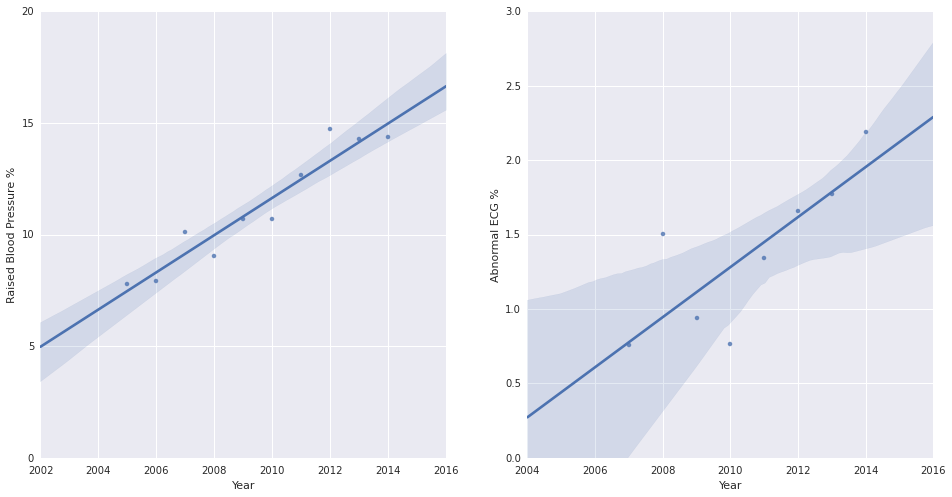

In [11]:
import seaborn
import matplotlib.pyplot as plt

# make the plots a bit bigger, so we can see what's going on
plt.figure(figsize=(16,8))

# Notes:
# 1 - we use the reset_index() method so we can get back access to 'Year' as a column rather than as the dataframe index
# 2 - we set 'ylim' on the resulting plot to force the Y axis to start at zero
plt.subplot(1, 2, 1)
seaborn.regplot('Year', 'Raised Blood Pressure %', data=df_relative.reset_index()).set(ylim=(0, None))

plt.subplot(1, 2, 2)
seaborn.regplot('Year', 'Abnormal ECG %', data=df_relative.reset_index()).set(ylim=(0, None))




The resulting plots show two things:

- the straight line that best fits the sample point - the incline of this line captures the "trend" of the data
- the shaded area indicates the 95% _confidence interval_ for the fit

We have to be wary about what the "confidence interval" means - with such a small sample size it's not really telling us how good our model is in real life - all it's showing us is how good a fit the line is to the sample data.

We can see that the 'Raised Blood Pressure %' model is a much "tighter" fit than the 'Abnormal ECG %' plot, so this is a good fit to the sample data, and is probably worth further investigation to see if it is statistically significant.

Combining with other data
--------------------------
There's another small dataset available on `data.gg`, and this contains an age-group breakdown of the number of yearly screenings:

In [12]:
json_totals = requests.get('http://data.gg/api/1.0/health/totals.json').text
df_totals = pandas.read_json(json_totals)
df_totals.set_index('Year', inplace=True)
df_totals.head()

,Age 25-34,Age 35-44,Age 45-54,Age 55-64,Age 65-69,Age 70-75,All screenings,New clients
Year,,,,,,,,
2005,152,407,496,574,235,0,1864,453
2006,136,379,594,597,238,0,1944,343
2007,142,471,571,573,223,3,1983,472
2008,129,436,611,605,212,6,1999,491
2009,127,473,656,644,229,4,2133,510


Could it be the case that age of people being screened is increasing, for whatever reason, and that this is contributing to the two trends we are seeing?

Let's take a look at the age group breakdowns visually:

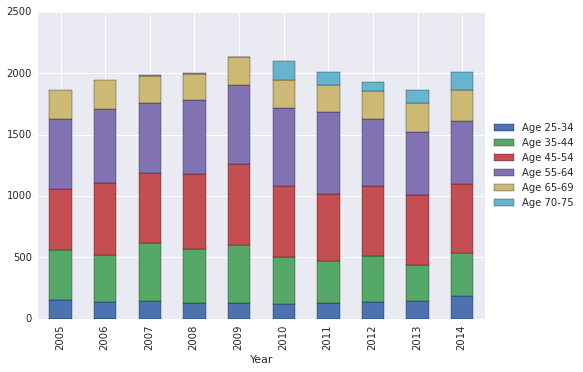

In [13]:
# select the columns we want to include in our stacked plot
age_group_columns = [
    'Age 25-34',
    'Age 35-44',
    'Age 45-54',
    'Age 55-64',
    'Age 65-69',
    'Age 70-75',
]
# create the plot, and move the legend to the right hand side
df_totals[age_group_columns].plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

It's not clear from the diagram that the screening ages are increasing, although we can see later appearances in the `Age 70-75` group.

Let's try to get a more accurate calculation of the average screening age.
Unfortunately, the samples have already been summarized into age group buckets, so we can't accurately compute the summary statistics we're interested in.
But we can create a 'rough' estimate by taking the centre point of each age range bucket and assuming all the people in that bucket are of that age.

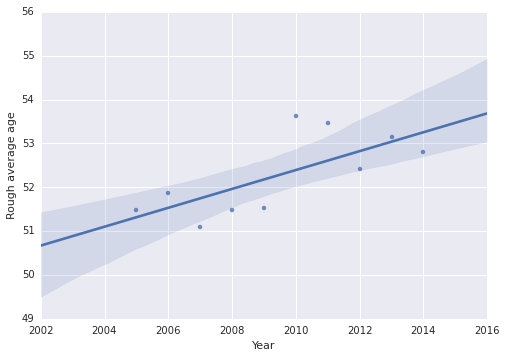

In [14]:
df_totals['Rough average age'] = (
    df_totals['Age 25-34'] * 30.0 +
    df_totals['Age 35-44'] * 40.0 +
    df_totals['Age 45-54'] * 50.0 +
    df_totals['Age 55-64'] * 60.0 +
    df_totals['Age 65-69'] * 67.5 +
    df_totals['Age 70-75'] * 72.5
) / df_totals['All screenings']

seaborn.regplot('Year', 'Rough average age', data=df_totals.reset_index())


So it looks like there is some evidence that the average screening age is increasing, and that this could be a factor in the increasing trends in the two concern types we saw earlier.

To be able to perform a more conclusive analysis, we would really like to go back to the original, unsummarized data to find the exact ages of the screenings that produced concerns and see if age is really a likely factor, or if we should look elsewhere.

What have we achieved?
-----------------------
In the few lines of code above we have:
- downloaded and parsed data from `data.gg`
- normalized occurrence rates against yearly totals
- 'eyeballed' graphs for each concern type to spot potential trends or anomalies
- started investigation of two concerns that suggest an increasing trend
- integrated data from another dataset

Next steps
----------
We have produced some simple linear models for 'Abnormal ECG %' and 'Raised Blood Pressure %'.
We could:
- apply further scrutiny to our linear models to assess how statistically robust they are likely to be
- when new data points become available, we can compare them against our models to see if they fit well, or signal a deviation
- look for other factors that may be responsible for the apparent trends - what might be causing higher rates of abnormal ECG and raised blood pressure?